<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [5]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [10]:
ls ../AlexYiZhou/

DSI Project 3.pptx        data_description.txt      project-03-starter.ipynb
README.md                 housing.csv


In [11]:
# Load the data
house = pd.read_csv('../AlexYiZhou/housing.csv')

In [12]:
house.shape

(1460, 81)

In [13]:
house['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [14]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Remove outliers

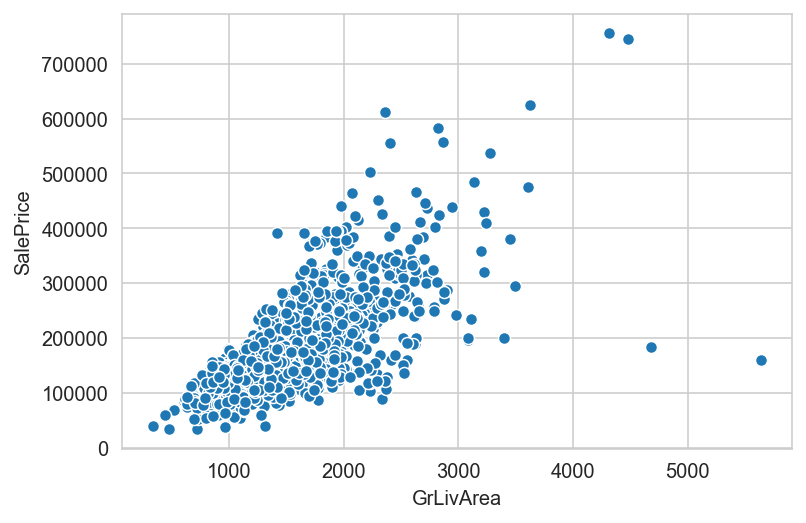

In [15]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=house)

In [16]:
house = house.drop(house.GrLivArea.sort_values()[-2:].index)

#### Dealing with missing data *

In [17]:
total = house.isnull().sum().sort_values(ascending=False).head(19)
percentage = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False).head(19)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
missing_data

,Total,Percentage
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556


           SalePrice  PoolArea
SalePrice    1.00000   0.09949
PoolArea     0.09949   1.00000


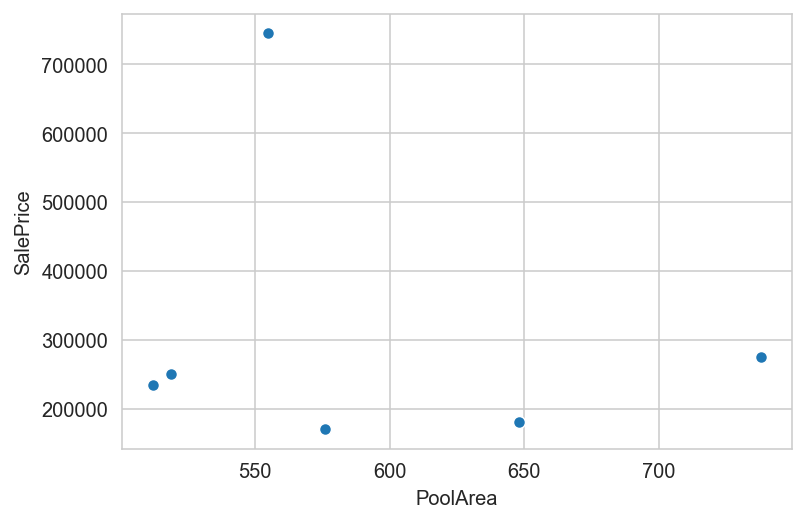

In [18]:
house['PoolQC'] = house['PoolQC'].fillna('None')
print(house[['SalePrice', 'PoolArea']].corr())
sns.scatterplot(house[house.PoolQC!='None']['PoolArea'], house[house.PoolQC!='None']['SalePrice'])

            SalePrice  Fireplaces
SalePrice    1.000000    0.469862
Fireplaces   0.469862    1.000000


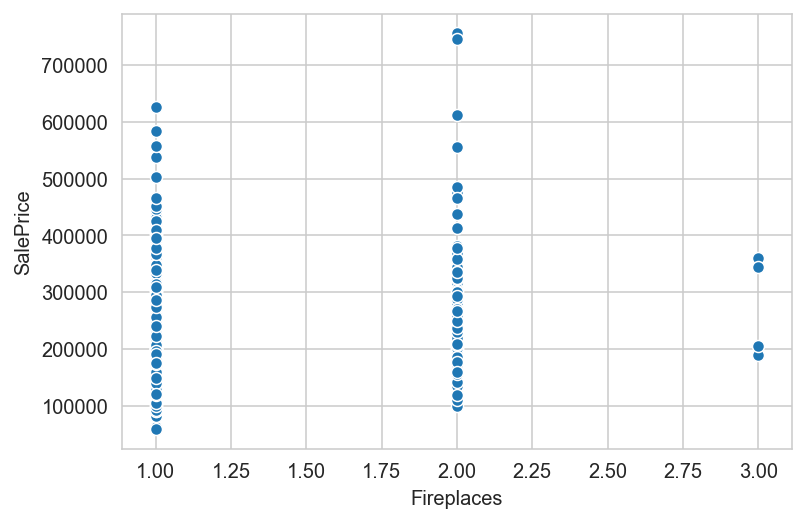

In [19]:
house['FireplaceQu'] = house['FireplaceQu'].fillna('None')
print(house[['SalePrice', 'Fireplaces']].corr())
sns.scatterplot(house[house.FireplaceQu!='None']['Fireplaces'], house[house.FireplaceQu!='None']['SalePrice'])

In [20]:
house_cleaned = house.drop(missing_data[missing_data.Total>1].index, 1)
house_cleaned = house_cleaned.drop(house.loc[house['Electrical'].isnull()].index)
house_cleaned.isnull().sum().max()

0

In [21]:
house_cleaned

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [22]:
house_cleaned

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


#### cited from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

In what concerns the remaining cases, we can see that 'GarageX' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20 𝑖𝑛5  problems). Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

#### Get dummies *

In [23]:
house_cleaned = pd.get_dummies(house_cleaned)

In [24]:
house_cleaned.shape

(1457, 221)

#### Remove skewness

In [25]:
house_cleaned.dtypes.value_counts()

uint8    186
int64     35
dtype: int64

In [26]:
# house_test = house_cleaned[house_cleaned.YearRemodAdd == 2010]
# house_train = house_cleaned.drop(house_test.index).reset_index(drop=True)

In [27]:
# finding skewed numeric features for train & test
skewness = house_cleaned.apply(lambda x: skew(x))
skewness = skewness[(skewness<-.5) | (skewness>.5)].index
house_cleaned[skewness] = np.log1p(house_cleaned[skewness])

# also for the test set
# house_test[skewness] = np.log1p(house_test[skewness])

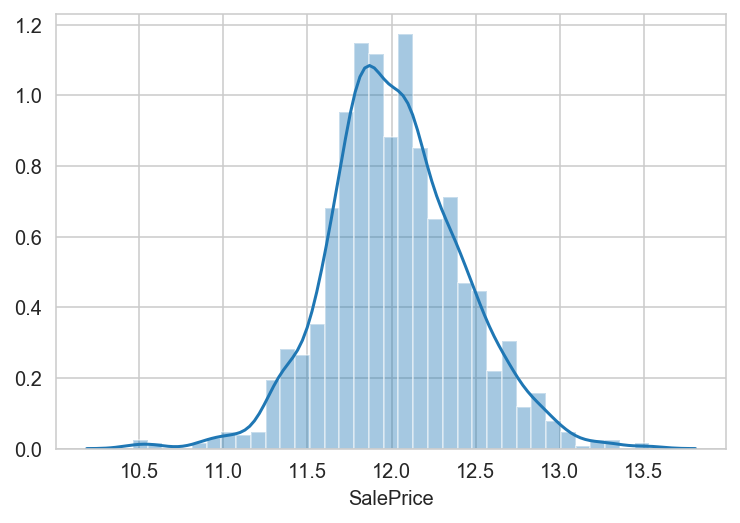

In [28]:
sns.distplot(house_cleaned['SalePrice'])

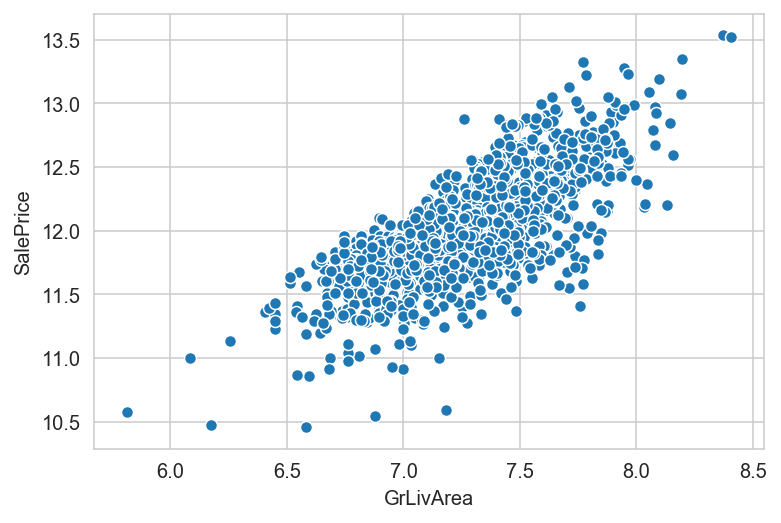

In [29]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=house_cleaned)

#### Modelling *

In [30]:
X_train = house_cleaned.drop(['SalePrice', 'Id'], 1)[house_cleaned.YrSold!=2010].reset_index(drop=True)
X_test = house_cleaned.drop(['SalePrice', 'Id'], 1)[house_cleaned.YrSold==2010].reset_index(drop=True)
y_train = house_cleaned[house_cleaned.YrSold!=2010].SalePrice.reset_index(drop=True)
y_test = house_cleaned[house_cleaned.YrSold==2010].SalePrice.reset_index(drop=True)

In [31]:
# ss = StandardScaler()
# ss.fit_transform(X_train)

In [32]:
def rmse_cv(model, X_train, y_train, cv=5):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = cv))
    return(rmse)

In [33]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
lasso.fit(X_train, y_train)
rmse_cv(lasso, X_train, y_train,).mean()

0.11542460159467896

In [34]:
coef = pd.Series(lasso.coef_, index = X_train.columns)

In [35]:
coef[coef!=0]

MSSubClass              -0.003676
LotArea                  0.085598
OverallQual              0.068059
OverallCond              0.252809
BsmtFinSF1               0.010489
                           ...   
SaleType_COD            -0.003728
SaleType_New             0.086324
SaleType_WD             -0.016827
SaleCondition_Abnorml   -0.084830
SaleCondition_Normal     0.006156
Length: 78, dtype: float64

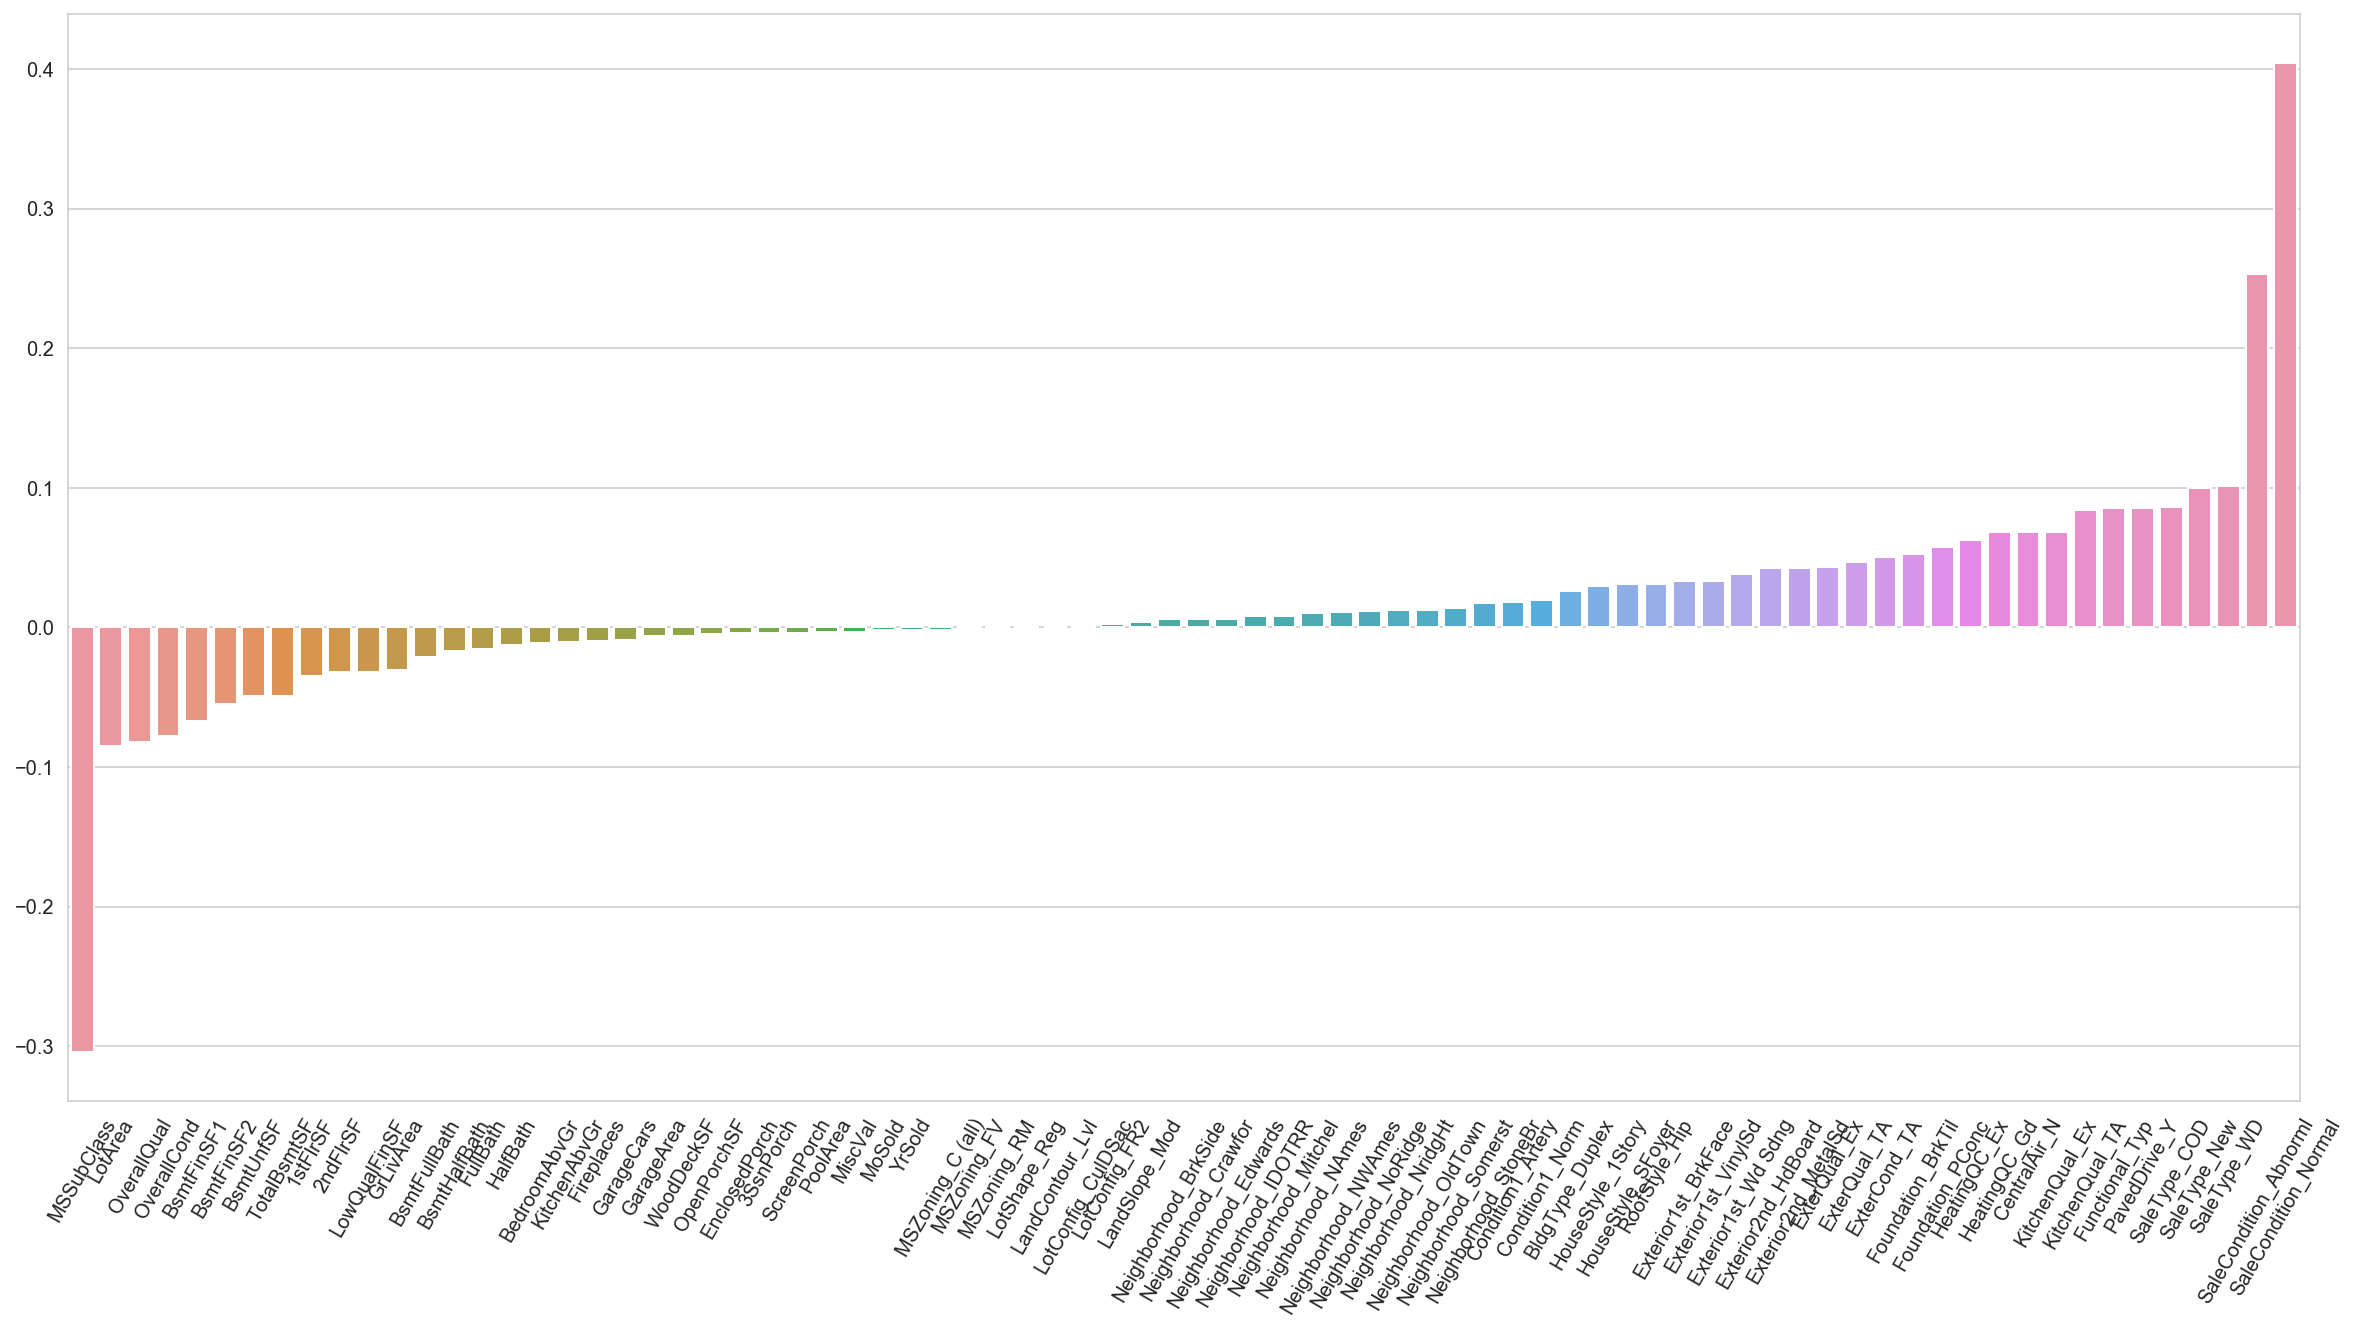

In [36]:
plt.figure(figsize=(20,10))
sns.barplot(x=coef[coef!=0].index, y=coef[coef!=0].sort_values())
plt.xticks(rotation=60)
plt.show()

In [37]:
selected_feat = coef[coef!=0].index
selected_feat


Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RM', 'LotShape_Reg',
       'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_Norm',
       'BldgType_Duplex', 'HouseSt

In [38]:
# by referencing data description:
fixed = ['MSSubClass', 'LotArea',  'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageCars',
       'GarageArea', 'MoSold', 'YrSold',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RM', 'LotShape_Reg',
       'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_Norm',
       'BldgType_Duplex', 'HouseStyle_1Story', 'HouseStyle_SFoyer',
        'Foundation_BrkTil',
       'Foundation_PConc', 'Functional_Typ', 
       'SaleType_COD', 'SaleType_New', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_Normal']

In [39]:
len(fixed)+len(renov)

NameError: name 'renov' is not defined

In [ ]:
rmse_cv(lasso, X_train[fixed], y_train).mean()

In [40]:
rmse_cv(LinearRegression(), X_train[fixed], y_train).mean()

0.14280791790367103

In [41]:
ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train[fixed], y_train).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.mean()

0.15033172656318156

In [42]:
mlr = LinearRegression()
mlr.fit(X_train[fixed], y_train)
y_pred = mlr.predict(X_test[fixed])
len(y_test)

175

In [43]:
test_pred = pd.concat([y_test, pd.Series(y_pred)], 1, keys=['Actual', 'Prediction'])

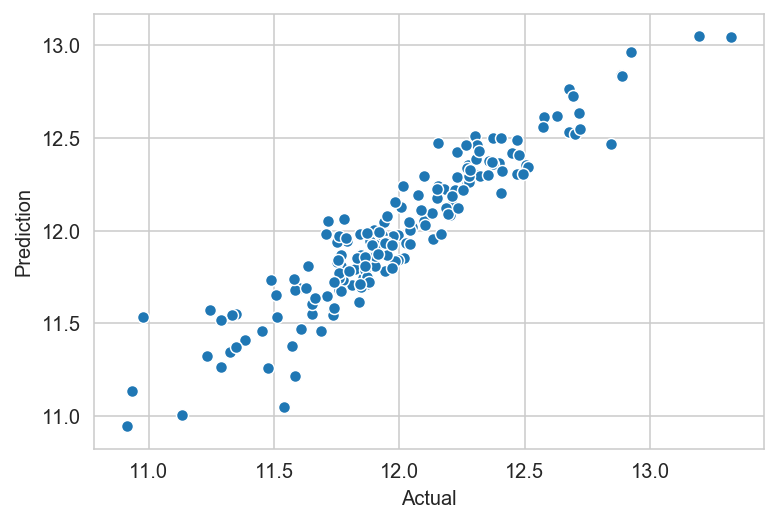

In [44]:
sns.scatterplot(test_pred.Actual, test_pred.Prediction)

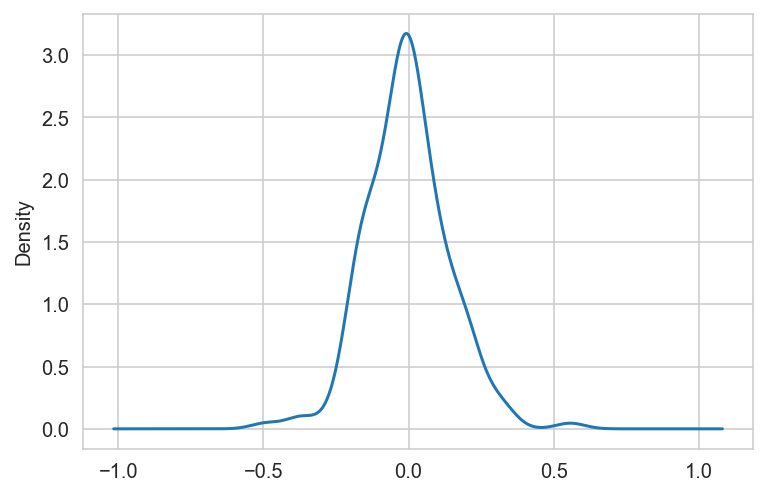

NameError: name 'renov' is not defined

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# test_pred.Prediction-test_pred.Actual

In [60]:



renov=['OverallQual', 'OverallCond','Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'RoofStyle_Hip', 'Exterior1st_BrkFace', 'Exterior1st_VinylSd',
       'Exterior1st_Wd Sdng', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
       'ExterQual_Ex', 'ExterQual_TA', 'ExterCond_TA','HeatingQC_Ex', 'HeatingQC_Gd', 'CentralAir_N',
       'KitchenQual_Ex', 'KitchenQual_TA', 'PavedDrive_Y']


X_test_renov = X_test[renov]
y_test_renov = (test_pred.Prediction-test_pred.Actual)

In [62]:
mlrenov = LinearRegression()
mlrenov.fit(X_test_renov, y_test_renov)
y_pred = mlrenov.predict(X_test_renov)
# len(y_test)

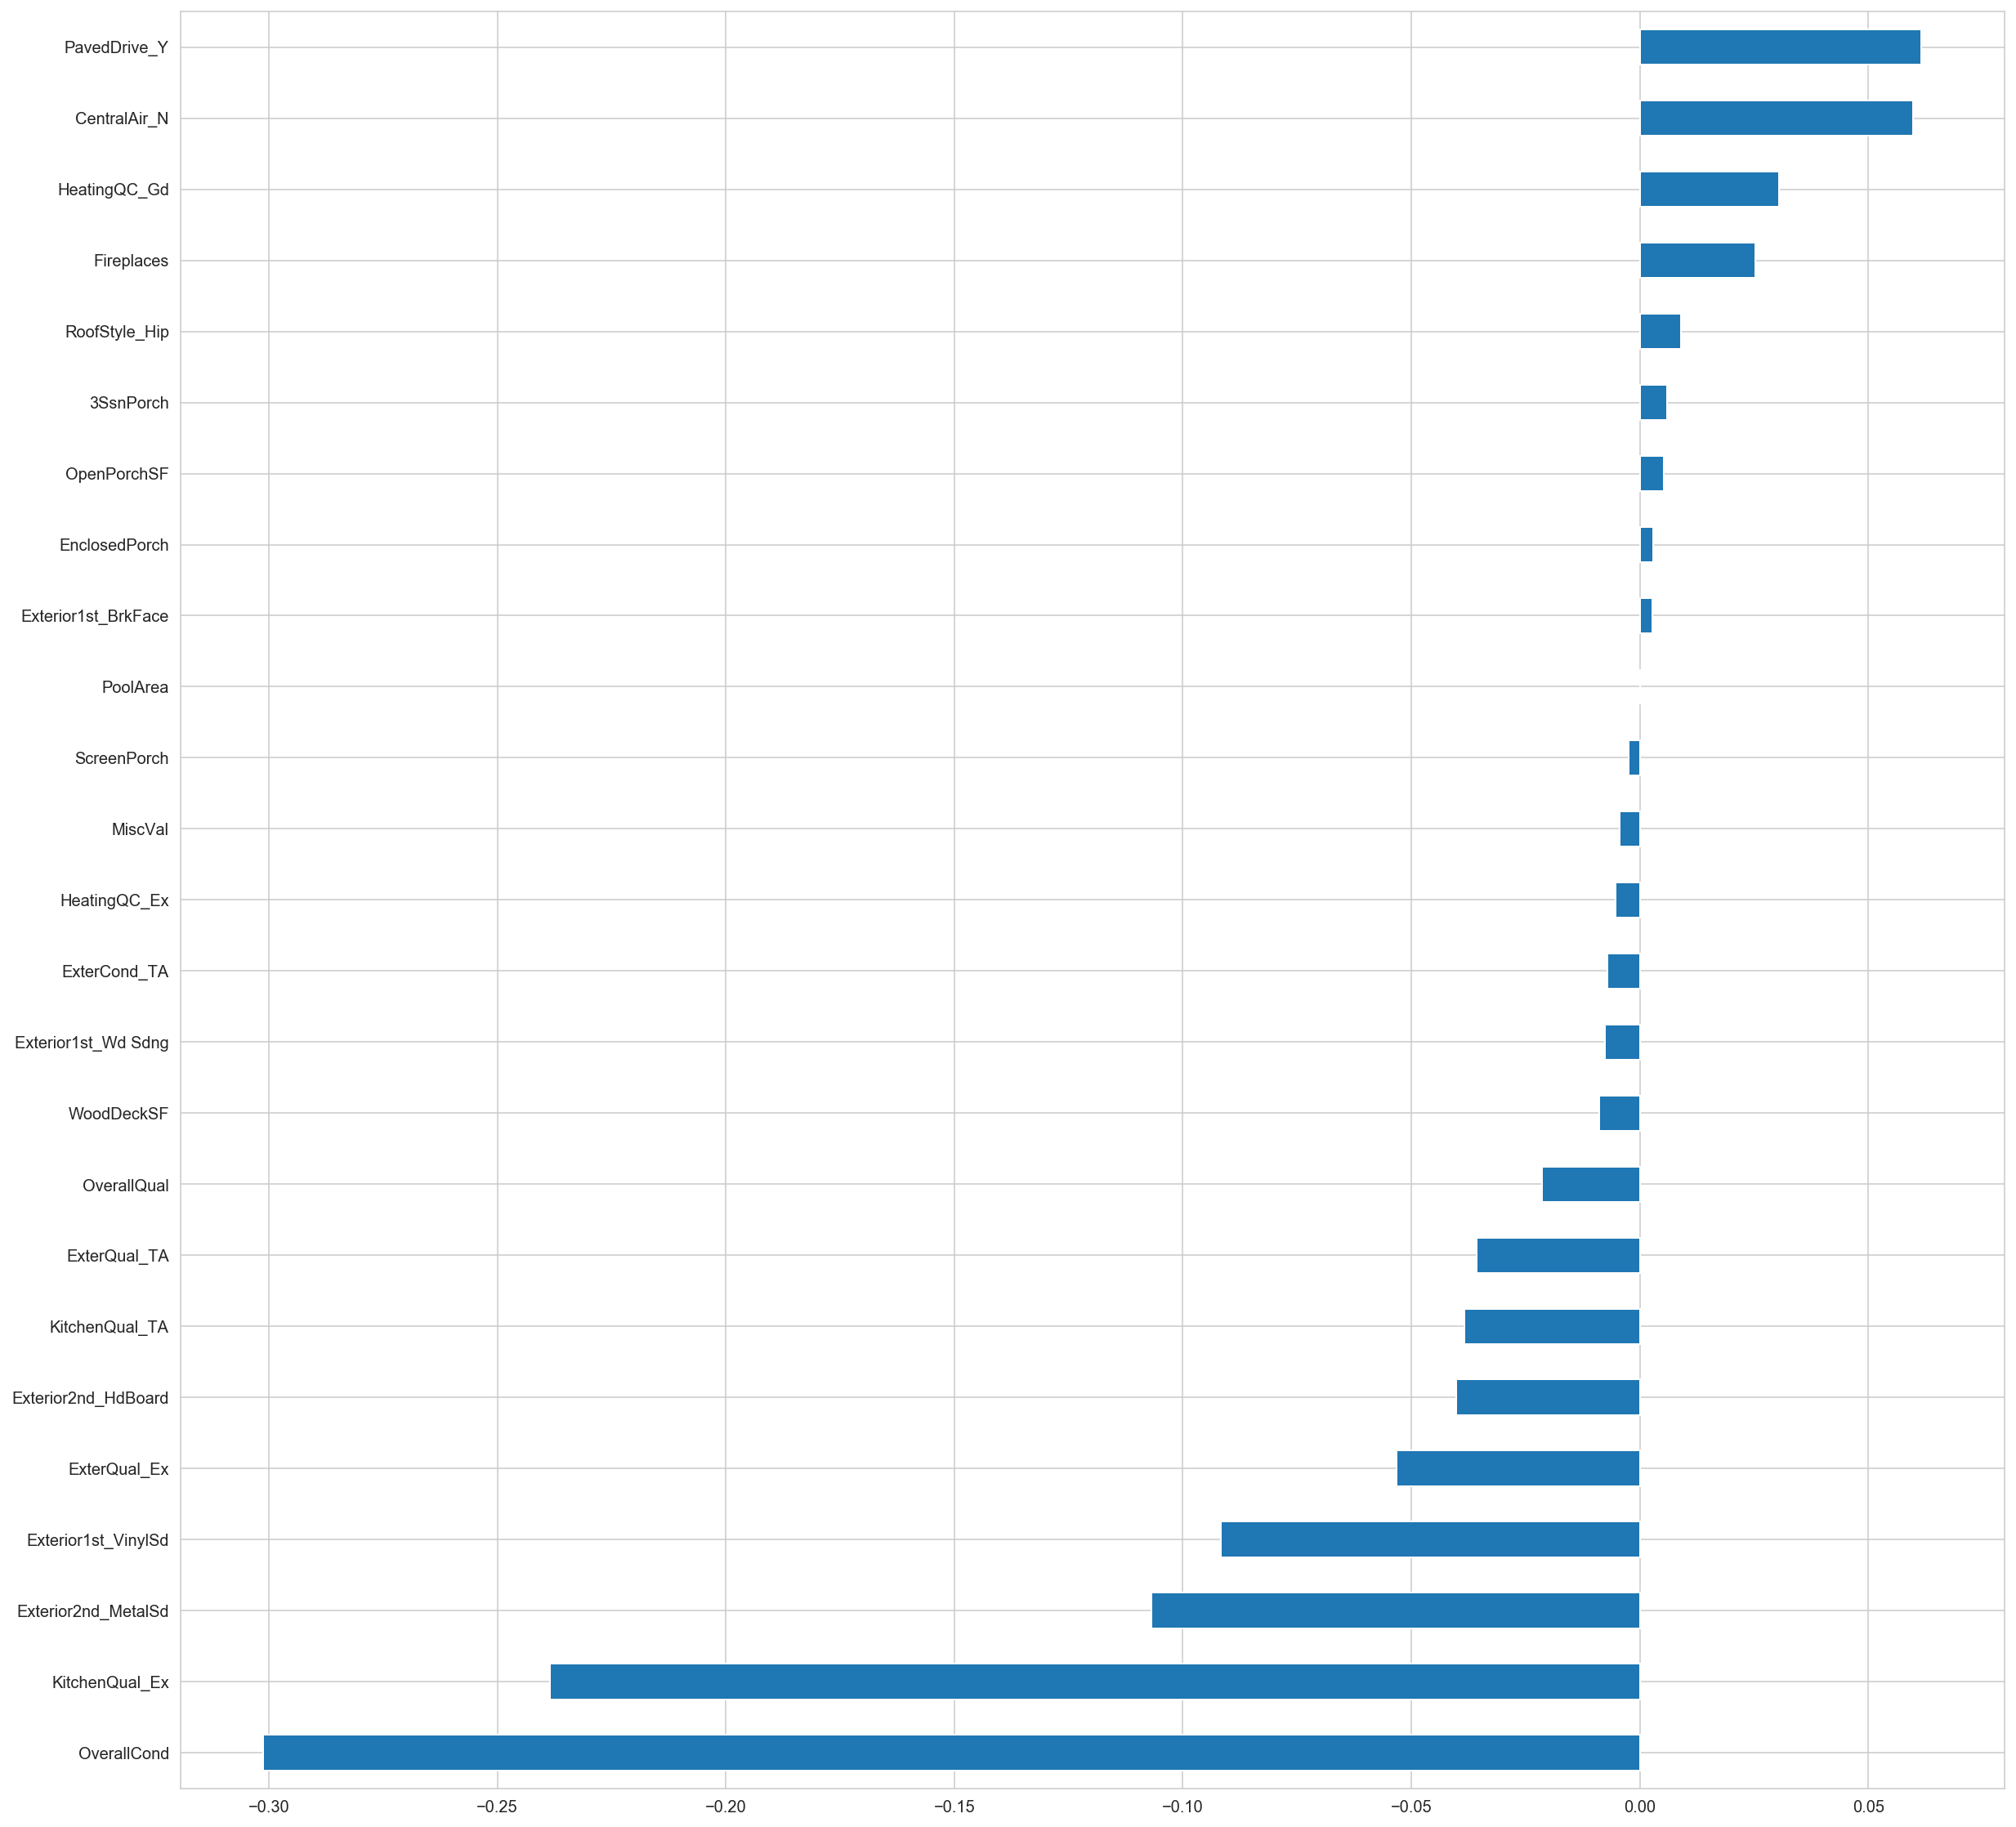

In [74]:
pd.Series(dict(zip(renov,mlrenov.coef_))).sort_values().plot.barh(figsize=(20,20))

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: